In [109]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import statsmodels.api as sm
from sklearn.metrics import classification_report
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [110]:
def encode_column(df, column_name):
    # Inicializamos el LabelEncoder
    le = LabelEncoder()
    
    # Aplicamos el encoding en la columna y almacenamos las clases para futuros usos
    df[column_name] = le.fit_transform(df[column_name])
    
    # Retornamos el dataframe y el LabelEncoder para transformaciones futuras
    return df, le

In [111]:
def encode_top_n(df, column_name, top_n=10):
    # Obtiene los top_n valores más frecuentes
    top_values = df[column_name].value_counts().nlargest(top_n).index
    
    # Reemplaza los valores menos frecuentes por 'otros'
    df[column_name] = df[column_name].apply(lambda x: x if x in top_values else "otros")
    df[column_name] = df[column_name].astype(str)
    # Aplica el LabelEncoder
    return df

In [112]:
def proces_data(df):

    numerical_vars = ["emi_amount", "age", "loan_term", 'cibil_score', 'irr', "requested_amount","disbursed"]
    categorical_vars = ["applicant_postal_code", "product_line", "segment"]

    df["applicant_postal_code"] = df["applicant_postal_code"].str.split(".").str[0].str.strip()
    df["applicant_postal_code"] = pd.to_numeric(df["applicant_postal_code"], errors="coerce").astype("Int64")

    df = encode_top_n(df, "applicant_postal_code", top_n=20)
    df, le_postal_code = encode_column(df, "applicant_postal_code")

    df = encode_top_n(df, "product_line", top_n=20)
    df, le_product = encode_column(df, "product_line")

    df, le_segment = encode_column(df, "segment")

    df["age"] = df["age"].astype(int)

    df_num = df[numerical_vars]

    # Convertimos las variables categóricas nominales a variables dummy
    df_applicant_posta_code = pd.get_dummies(df['applicant_postal_code'], prefix='postal_code')
    df_applicant_posta_code = df_applicant_posta_code.astype(int)

    # Convertimos las variables categóricas nominales a variables dummy
    df_product = pd.get_dummies(df['product_line'], prefix='product')
    df_product = df_product.astype(int)

    # Convertimos las variables categóricas nominales a variables dummy
    df_segment = pd.get_dummies(df['segment'], prefix='segment')
    df_segment = df_segment.astype(int)

    # Unimos los dataframe incluyendo las variables dummy
    df_final_transform = pd.merge(df_num, df_applicant_posta_code, left_index=True, right_index=True)
    df_final_transform = pd.merge(df_final_transform, df_product, left_index=True, right_index=True)
    df_final_transform = pd.merge(df_final_transform, df_segment, left_index=True, right_index=True)

    df_final_transform["cibil_score"] = np.where(df_final_transform["cibil_score"]<1, 1, df_final_transform["cibil_score"])

    df_final_transform['emi_amount_log'] = np.log(df_final_transform['emi_amount'])
    df_final_transform['age_log'] = np.log(df_final_transform['age'])
    df_final_transform['loan_term_log'] = np.log(df_final_transform['loan_term'])
    df_final_transform['cibil_score_log'] = np.log(df_final_transform['cibil_score'])
    df_final_transform['irr_log'] = np.log(df_final_transform['irr'])

    return df_final_transform

In [113]:
def fit_logit_model(df, variables_x, variables_y):
    Y = df[variables_y]
    X = df[variables_x]
    X = sm.add_constant(X, prepend=False)

    model_logit = sm.Logit(endog=Y, exog=X).fit()
    print(model_logit.summary())

    Y_pred = model_logit.predict(X).round(0).astype(int)
    # Reporte de métricas
    reporte = classification_report(Y, Y_pred, labels=[1, 0])
    print("Reporte de clasificación:\n", reporte)
    return model_logit

In [114]:
df = pd.read_pickle("../output/base_etapa_1.pkl")

In [115]:
df_process = proces_data(df)

In [116]:
df_process.corr()[["disbursed"]].sort_values(by=["disbursed"]).head(10)

,disbursed
irr_log,-0.632865
irr,-0.621878
loan_term,-0.058891
loan_term_log,-0.051708
product_4,-0.044242
postal_code_11,-0.031517
product_1,-0.031420
product_19,-0.030676
postal_code_3,-0.030586
product_15,-0.028664


In [117]:
df_process.corr()[["disbursed"]].sort_values(by=["disbursed"]).tail(10)

,disbursed
postal_code_19,0.028166
product_17,0.030593
cibil_score,0.031909
product_8,0.034406
segment_1,0.035241
postal_code_6,0.035585
age,0.035676
age_log,0.036669
product_20,0.060693
disbursed,1.000000


In [118]:
variables_x = ["irr_log", 'loan_term_log', 'age_log']
variables_y = "disbursed"

In [119]:
model_general = fit_logit_model(df_process, variables_x, variables_y)

Optimization terminated successfully.
         Current function value: 0.428671
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              disbursed   No. Observations:                12055
Model:                          Logit   Df Residuals:                    12051
Method:                           MLE   Df Model:                            3
Date:                Tue, 29 Oct 2024   Pseudo R-squ.:                  0.3769
Time:                        01:30:44   Log-Likelihood:                -5167.6
converged:                       True   LL-Null:                       -8292.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
irr_log         -15.8314      0.303    -52.324      0.000     -16.424     -15.238
loan_term_log    -0.

In [120]:
df_process['const'] = 1.0
df_process['prob_T1'] = model_general.predict(df_process[variables_x + ["const"]])

In [121]:
df_process.to_pickle("../output/base_etapa_2.pkl")

In [122]:
df_process[["irr", "loan_term", "age"]].describe()

,irr,loan_term,age
count,12055.000000,12055.000000,12055.000000
mean,19.843160,43.582829,38.009954
std,2.956696,11.071337,9.743316
min,16.500000,11.000000,18.000000
25%,17.400000,36.000000,30.000000
50%,18.600000,36.000000,37.000000
75%,22.200000,48.000000,44.000000
max,26.500000,60.000000,69.000000


In [123]:
rango_irr = np.arange(17, 27, 0.1)
df_simulacion = pd.DataFrame(rango_irr)
df_simulacion = df_simulacion.rename({0: 'irr'}, axis=1)
df_simulacion["emi_amount"] = 12200
df_simulacion["age"] = 36
df_simulacion["loan_term"] = 36
df_simulacion['emi_amount_log'] = np.log(df_simulacion['emi_amount'])
df_simulacion['age_log'] = np.log(df_simulacion['age'])
df_simulacion['irr_log'] = np.log(df_simulacion['irr'])
df_simulacion['loan_term_log'] = np.log(df_simulacion['loan_term'])

df_simulacion['const'] = 1.0

In [124]:
df_simulacion['prob_T1'] = model_general.predict(df_simulacion[variables_x + ["const"]])

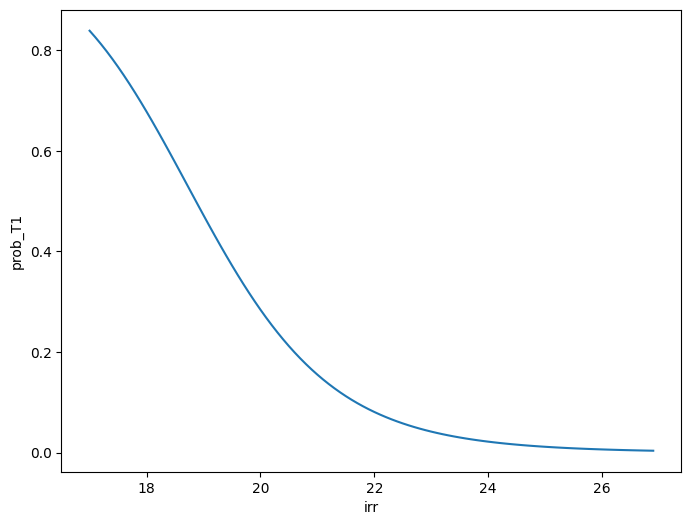

In [125]:
# Create a figure and axis
plt.figure(figsize=(8, 6))
# Plot the line
sns.lineplot(x='irr', y='prob_T1', data=df_simulacion)
# Display the plot
plt.show()